In [8]:
#load necessary libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [3]:
#checking for device processing if cuda appears it is ccomparatively faster.
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
#transform function is used for data preprocessing 
#Resize function to get images of same size and width
#RandomHorizontalFlip Horizontally flips the given image randomly with a given probability.by default p=0.5. increases the dataset by 2
#totensor changes the pixel range 0-255 to 0-1, numpy to tensors as pytorch takes tensors as input.
#Normalize has a 2 * 3 matrix with mean and standard deviation and RGB values with default values 0.5

transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std z-score normalization
                        [0.5,0.5,0.5])
])

In [14]:
#In pytorch data is fed in the form of data loaders which helps in reading the data and feed the data to the model in batches which ensures memory overload doesnt causes.
#Path for training and testing directory
#This step is for loading the images in batches and shuffle is set to true so that it is not bias to some categories and randomizes the order.
train_path='D:/ananya/research/intel_classifier/archive/seg_train/seg_train'
test_path='D:/ananya/research/intel_classifier/archive/seg_test/seg_test'
train_loader= DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader= DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [15]:
#Fetch all the classes, categories ,names
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [16]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            

In [18]:
model=ConvNet(num_classes=6).to('cpu')

In [19]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [20]:
num_epochs=10

In [21]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [22]:
print(train_count,test_count)

14034 3000


Epoch: 0 Train Loss: tensor(2.7815) Train Accuracy: 0.7204645860054154 Test Accuracy: 0.594
Epoch: 1 Train Loss: tensor(1.5424) Train Accuracy: 0.7971355280034202 Test Accuracy: 0.667
Epoch: 2 Train Loss: tensor(0.9362) Train Accuracy: 0.8405301410859342 Test Accuracy: 0.741
Epoch: 3 Train Loss: tensor(0.4669) Train Accuracy: 0.8905515177426251 Test Accuracy: 0.7546666666666667
Epoch: 4 Train Loss: tensor(0.2865) Train Accuracy: 0.9257517457602964 Test Accuracy: 0.7326666666666667
Epoch: 5 Train Loss: tensor(0.2067) Train Accuracy: 0.9447769702151917 Test Accuracy: 0.763
Epoch: 6 Train Loss: tensor(0.1542) Train Accuracy: 0.9544677212483967 Test Accuracy: 0.7296666666666667
Epoch: 7 Train Loss: tensor(0.1012) Train Accuracy: 0.9686475701866895 Test Accuracy: 0.7666666666666667
Epoch: 8 Train Loss: tensor(0.1132) Train Accuracy: 0.966652415562206 Test Accuracy: 0.6936666666666667
Epoch: 9 Train Loss: tensor(0.1306) Train Accuracy: 0.963517172580875 Test Accuracy: 0.7333333333333333


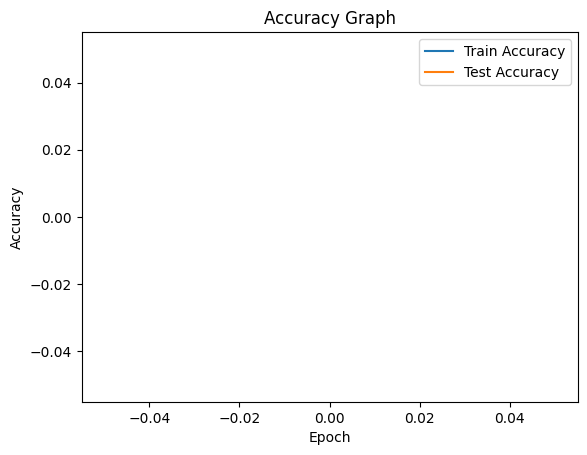

In [24]:
import matplotlib.pyplot as plt

# Create lists to store accuracy values

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
        
# Plot the accuracy graph


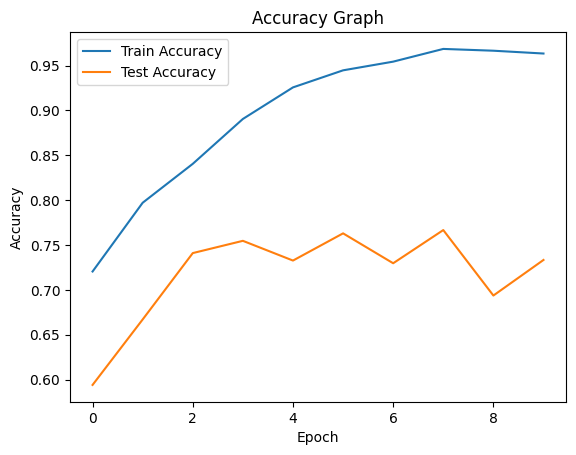

In [28]:
train_accuracy_list = [0.7204645860054154,0.7971355280034202,0.8405301410859342,0.8905515177426251,0.9257517457602964,0.9447769702151917,0.9544677212483967,0.9686475701866895,0.966652415562206,0.963517172580875]
test_accuracy_list = [0.594,0.667,0.741,0.7546666666666667,0.7326666666666667,0.763,0.7296666666666667,0.7666666666666667,0.6936666666666667,0.7333333333333333]
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.show()
